In [40]:
import pandas as pd
import numpy as np

from __future__ import print_function
import time

from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpld3
from matplotlib.offsetbox import AnchoredText

import plotly.express as px

import seaborn as sns

pd.set_option('display.max_rows', 500)

In [41]:
class QDA:
    def fit(self, X, t):
        self.priors = dict()
        self.means = dict()
        self.covs = dict()
        
        self.classes = np.unique(t)
        
        for c in self.classes:
            X_c = X[t == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = np.mean(X_c, axis=0)
            self.covs[c] = np.cov(X_c, rowvar=False)
    
    def predict(self, X):
        preds = list()
        for x in X:
            posts = list()
            for c in self.classes:
                prior = np.log(self.priors[c])
                inv_cov = np.linalg.inv(self.covs[c])
                inv_cov_det = np.linalg.det(inv_cov)
                diff = x-self.means[c]
                likelihood = 0.5*np.log(inv_cov_det) - 0.5*diff.T @ inv_cov @ diff
                post = prior + likelihood
                posts.append(post)
            pred = self.classes[np.argmax(posts)]
            preds.append(pred)
        return np.array(preds)

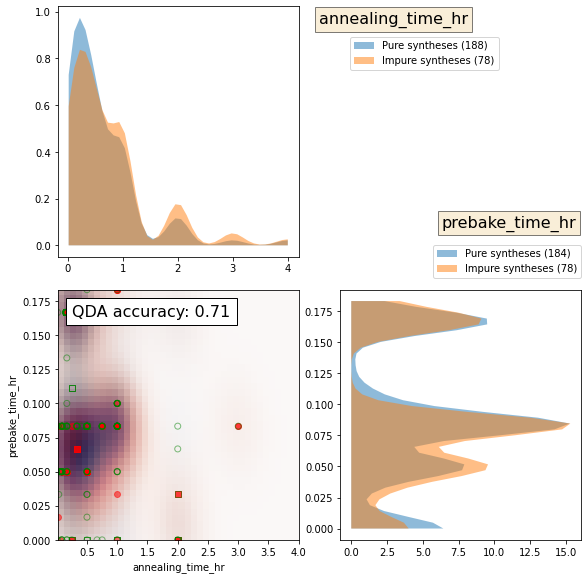

In [42]:
codified_df = pd.read_csv('./data/BFO_film_synth_df_codified_20211101.csv')
refined_df = pd.read_csv('./data/BFO_film_synth_df_refined_20211101.csv')

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

#set up pure and impure data series

params_of_interest = [
    #'annealing_temperature_degC',
    #'bi_fe_ratio',
    'annealing_time_hr',
    #'precursor_concentration',
    #'stirring_temp_degC',
    #'prebake_degC',
    'prebake_time_hr',
    #'carbonyl'
]

N = len(params_of_interest)

Fig, axs = plt.subplots(N, N, figsize=(8,8))
Fig.tight_layout(h_pad=1.2)

for i, x_param in enumerate(params_of_interest):
    
    textstr = x_param
    
    #optionally, remove outliers
    if x_param in ['prebake_time_hr', 'annealing_time_hr']:
        if x_param == 'prebake_time_hr':
            thresh = 0.2
        elif x_param == 'annealing_time_hr':
            thresh = 4
        codified_df[x_param] = codified_df[[x_param]].apply(
            lambda rec: None if rec[x_param]>thresh else rec[x_param],
            axis=1
        )
    
    x = codified_df[~codified_df[x_param].isnull()][['recipe_id', x_param]]
    x_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_pure = x_pure_df[x_param]
    x_impure = x_impure_df[x_param]
    
    x_pure_chel = codified_df[
        (codified_df['impurity_code']==0) &
        (~codified_df[x_param].isnull()) &
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    x_impure_chel = codified_df[
        (codified_df['impurity_code']==1) &
        (~codified_df[x_param].isnull()) &
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    joined_pure = x_pure_df.merge(
        x_pure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    
    joined_impure = x_impure_df.merge(
        x_impure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    x_pure_nochel = joined_pure[
        joined_pure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    x_impure_nochel = joined_impure[
        joined_impure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    
    assert(len(x_pure_nochel)+len(x_pure_chel)==len(x_pure))
    assert(len(x_impure_nochel)+len(x_impure_chel)==len(x_impure))
    
    x_min = min(min(x_pure), min(x_impure))
    x_max = max(max(x_pure), max(x_impure))
    
    xgrid = np.linspace(x_min, x_max, 40)
    
    pure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    pure_kde.fit(np.asarray(x_pure).reshape(-1,1))
    pure_logprob = pure_kde.score_samples(xgrid.reshape(-1,1))
    
    impure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    impure_kde.fit(np.asarray(x_impure).reshape(-1,1))
    impure_logprob = impure_kde.score_samples(xgrid.reshape(-1,1))
    
    if i < len(params_of_interest)-1:
        axs[i,i].fill_between(xgrid, np.exp(pure_logprob), alpha=0.5, label="Pure syntheses ({})".format(len(x_pure)))
        axs[i,i].fill_between(xgrid, np.exp(impure_logprob), alpha=0.5, label="Impure syntheses ({})".format(len(x_impure)))
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(1.85, 0.9))
        
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(1.085, 0.98, textstr, transform=axs[i,i].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    else:
        axs[i,i].fill_betweenx(xgrid, np.exp(pure_logprob), alpha=0.5, label="Pure syntheses ({})".format(len(x_pure)))
        axs[i,i].fill_betweenx(xgrid, np.exp(impure_logprob), alpha=0.5, label="Impure syntheses ({})".format(len(x_impure)))
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(1.02, 1.2))
        
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(0.42, 1.3, textstr, transform=axs[i,i].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    
    for j, y_param in enumerate(params_of_interest):
        if j>i:
            #optionally, remove outliers
            if y_param in ['prebake_time_hr', 'annealing_time_hr']:
                if y_param == 'prebake_time_hr':
                    thresh = 0.2
                elif y_param == 'annealing_time_hr':
                    thresh = 4
                codified_df[y_param] = codified_df[[y_param]].apply(
                    lambda rec: None if rec[y_param]>thresh else rec[y_param],
                    axis=1
                )
            y = codified_df[~codified_df[y_param].isnull()][y_param]

            idx = [idx for idx in list(x.index) if idx in list(y.index)]

            y_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[y_param].isnull())]       
            
            y_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[y_param].isnull())]
            
            y_pure = y_pure_df[y_param]
            y_impure = y_impure_df[y_param]

            y_pure_chel = codified_df[
                (codified_df['impurity_code']==0) &
                (~codified_df[y_param].isnull()) &
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            y_impure_chel = codified_df[
                (codified_df['impurity_code']==1) &
                (~codified_df[y_param].isnull()) &
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            joined_pure = y_pure_df.merge(
                y_pure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]


            joined_impure = y_impure_df.merge(
                y_impure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]

            y_pure_nochel = joined_pure[
                joined_pure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            y_impure_nochel = joined_impure[
                joined_impure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            
            pure_idx = [idx for idx in list(x_pure.index) if idx in list(y_pure.index)]
            pure_chel_idx = [rec_id for rec_id in x_pure_chel['recipe_id'].to_list() if rec_id in y_pure_chel['recipe_id'].to_list()]
            pure_nochel_idx = [rec_id for rec_id in x_pure_nochel['recipe_id'].to_list() if rec_id in y_pure_nochel['recipe_id'].to_list()]
            
            impure_idx = [idx for idx in x_impure.index if idx in y_impure.index]
            impure_chel_idx = [rec_id for rec_id in x_impure_chel['recipe_id'].to_list() if rec_id in y_impure_chel['recipe_id'].to_list()]
            impure_nochel_idx = [rec_id for rec_id in x_impure_nochel['recipe_id'].to_list() if rec_id in y_impure_nochel['recipe_id'].to_list()]

            pure_data = np.vstack([x_pure.loc[pure_idx],y_pure.loc[pure_idx]])
            impure_data = np.vstack([x_impure.loc[impure_idx],y_impure.loc[impure_idx]])
            
            y_min = min(min(y_pure), min(y_impure))
            y_max = max(max(y_pure), max(y_impure))
            
            ygrid = np.linspace(y_min, y_max, 40)

            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            
            pure_kde = gaussian_kde(pure_data)
            Z_pure = pure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

            impure_kde = gaussian_kde(impure_data)
            Z_impure = impure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

            pure_param_dist = axs[j,i].imshow(Z_pure.reshape(Xgrid.shape), 
                       origin='lower',
                       aspect='auto', 
                       extent=[x_min, x_max, y_min, y_max],
                       cmap="Blues",
                       alpha=1)
            
            impure_param_dist = axs[j,i].imshow(Z_impure.reshape(Xgrid.shape), 
                       origin='lower',
                       aspect='auto', 
                       extent=[x_min, x_max, y_min, y_max],
                       cmap="Reds",
                       alpha=0.5)

            #imp_x = codified_df[codified_df['impurity_code']==1][x_param]
            #imp_y = codified_df[codified_df['impurity_code']==1][y_param]
            #pur_x = codified_df[codified_df['impurity_code']==0][x_param]
            #pur_y = codified_df[codified_df['impurity_code']==0][y_param]

            axs[j,i].scatter(x_impure_chel.loc[x_impure_chel['recipe_id'].isin(impure_chel_idx)][x_param], y_impure_chel.loc[y_impure_chel['recipe_id'].isin(impure_chel_idx)][y_param], c='r', alpha=0.5, marker='s')
            axs[j,i].scatter(x_pure_chel.loc[x_pure_chel['recipe_id'].isin(pure_chel_idx)][x_param], y_pure_chel.loc[y_pure_chel['recipe_id'].isin(pure_chel_idx)][y_param], facecolors='none', edgecolors='green', alpha=0.5, marker='s')

            axs[j,i].scatter(x_impure_nochel.loc[x_impure_nochel['recipe_id'].isin(impure_nochel_idx)][x_param], y_impure_nochel.loc[y_impure_nochel['recipe_id'].isin(impure_nochel_idx)][y_param], c='r', alpha=0.5)
            axs[j,i].scatter(x_pure_nochel.loc[x_pure_nochel['recipe_id'].isin(pure_nochel_idx)][x_param], y_pure_nochel.loc[y_pure_nochel['recipe_id'].isin(pure_nochel_idx)][y_param], facecolors='none', edgecolors='green', alpha=0.5)

            axs[j,i].set_xlabel(x_param)
            axs[j,i].set_ylabel(y_param)
            
            #QDA
            X = pd.concat([refined_df[x_param], refined_df[y_param]], axis=1).to_numpy()
            t = refined_df['impurity_code'].to_numpy()

            qda = QDA()
            qda.fit(X, t)
            preds = qda.predict(X)

            correct = 0
            for true, pred in zip(t, preds):
                if true == pred:
                    correct +=1 
                    
            qda_accuracy = correct/len(t)
            
            anchored_text = AnchoredText(
                "QDA accuracy: {0:.2f}".format(qda_accuracy), 
                loc=2,
                prop=dict(fontsize=16)
            )
            axs[j,i].add_artist(anchored_text)

        elif j!=i:
            Fig.delaxes(axs[j,i])

plt.show()
Fig.savefig('annealtime_prebaketime_qda.png', bbox_inches="tight")